In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import time
import itertools
import os

if torch.backends.mps.is_available():
    device = torch.device("mps")  # GPU Apple Silicon
else:
    device = torch.device("cpu")


In [2]:
# Caricamento dataset
data_dir = "/Users/elisaquadrini/Desktop/DEEP LEARNING /MATERIALE PER PROGETTO/ParkingLotCounting/parking/clf-data"   # cartella che contiene empty/ e not_empty/

# Carichiamo SOLO per fare analisi
raw_dataset = datasets.ImageFolder(data_dir)
raw_dataset.classes, raw_dataset.class_to_idx

(['empty', 'not_empty'], {'empty': 0, 'not_empty': 1})

In [3]:
# Conteggio immagini

from collections import Counter

labels = [label for _, label in raw_dataset]
Counter(labels)


Counter({0: 3045, 1: 3045})

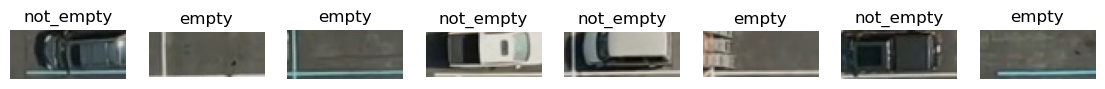

In [4]:
# Visualizzare alcune immagini random di entrmabe le classi
import random

def show_samples_balanced(dataset, n=6):
    plt.figure(figsize=(14, 5))
    indices = random.sample(range(len(dataset)), n)
    
    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(dataset.classes[label])
        plt.axis("off")

show_samples_balanced(raw_dataset, n=8)




In [5]:
# Check dimensione immagini in termini di Pixel
from PIL import Image
import os

sample_path = os.path.join(data_dir, raw_dataset.samples[0][0])
img = Image.open(sample_path)
img.size


(69, 29)

In [6]:
# We resize the images in order to apply our net
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    transforms.RandomRotation(10),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.05, 0.05),
        scale=(0.9, 1.1)
    ),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.45, 0.45, 0.45],
                         std=[0.18, 0.18, 0.18])
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.45, 0.45, 0.45],
                         std=[0.18, 0.18, 0.18])
])



In [7]:
full_dataset = datasets.ImageFolder(data_dir, transform=train_transform)

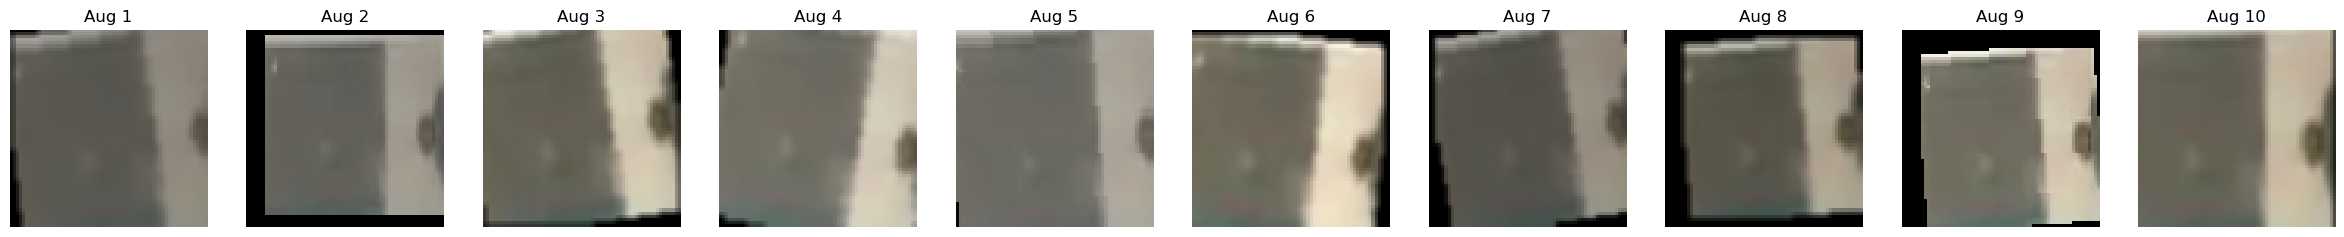

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def show_augmented_images_from_dataset(dataset, index, n=8):
    """
    Applica augmentation n volte all'immagine dataset[index].
    """
    img_path, _ = dataset.samples[index]
    original = Image.open(img_path).convert("RGB")

    transform = dataset.transform

    fig, axes = plt.subplots(1, n, figsize=(3*n, 4))

    # mean/std del TUO dataset
    mean = np.array([0.45, 0.45, 0.45])
    std  = np.array([0.18, 0.18, 0.18])

    for i in range(n):
        aug = transform(original)
        aug = aug.numpy().transpose(1, 2, 0)  # C→HWC

        # de-normalize
        aug = aug * std + mean
        aug = np.clip(aug, 0, 1)

        axes[i].imshow(aug)
        axes[i].set_title(f"Aug {i+1}")
        axes[i].axis("off")

    plt.show()


show_augmented_images_from_dataset(full_dataset, index=10, n=10)

In [9]:
from torch.utils.data import random_split
from torchvision import datasets

# 1. Carichiamo il dataset con il TRAIN TRANSFORM
full_dataset = datasets.ImageFolder(data_dir, transform=train_transform)

# 2. Calcoliamo le dimensioni
total_size = len(full_dataset)
val_size = int(0.15 * total_size)
test_size = int(0.15 * total_size)
train_size = total_size - val_size - test_size

# 3. Facciamo lo split
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, val_size, test_size]
)

# 4. Cambiamo i transform di VALIDAZIONE e TEST
val_dataset.dataset.transform = test_transform
test_dataset.dataset.transform = test_transform

# 5. Creiamo i dataloader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [10]:
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F

class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # --- Convolutional layers ---
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # 64→32

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # 32→16

        # automatically compute flatten dim
        self.flatten_dim = self._get_flatten_dim()

        # --- Fully connected layers ---
        self.fc1 = nn.Linear(self.flatten_dim, 128)
        self.fc2 = nn.Linear(128, 2)

    def _get_flatten_dim(self):
        """ Computes the correct flatten dimension after conv layers. """
        with torch.no_grad():
            x = torch.zeros(1, 3, 64, 64)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = self.pool1(x)
            x = F.relu(self.conv3(x))
            x = self.pool2(x)
            return x.view(1, -1).shape[1]

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)

        x = F.relu(self.conv3(x))
        x = self.pool2(x)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

Shuffle è applicato solo al training perché l’ottimizzazione stocastica richiede campioni in ordine casuale per garantire una buona convergenza e ridurre le correlazioni tra batch. Validation e test non devono essere shufflati perché servono a misurare le prestazioni in modo stabile, deterministico e riproducibile.

In [11]:
def init_weights_kaiming(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode="fan_in", nonlinearity="relu")
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [12]:
model = SmallCNN().to(device)
model.apply(init_weights_kaiming)

SmallCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [14]:
num_epochs = 30

history = {
    "train_loss": [], "val_loss": [],
    "train_acc": [], "val_acc": []
}

best_val_loss = float("inf")
CHECKPOINT_PATH = "best_model.pth"

for epoch in range(num_epochs):

    ##################################
    #            TRAIN                #
    ##################################
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total

    ##################################
    #            VALIDATION           #
    ##################################
    model.eval()
    val_running_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / len(val_loader.dataset)
    val_acc = val_correct / val_total

    ##################################
    #       SAVE METRICS             #
    ##################################
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    ##################################
    #           CHECKPOINT            #
    ##################################
    if val_loss < best_val_loss:
        torch.save(model.state_dict(), CHECKPOINT_PATH)
        best_val_loss = val_loss
        print(" ✓ Saved new best model")

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")



 ✓ Saved new best model
Epoch 1/30 | Train Loss: 1.3227 | Train Acc: 0.9327 | Val Loss: 0.0041 | Val Acc: 0.9978
 ✓ Saved new best model
Epoch 2/30 | Train Loss: 0.0007 | Train Acc: 1.0000 | Val Loss: 0.0002 | Val Acc: 1.0000
 ✓ Saved new best model
Epoch 3/30 | Train Loss: 0.0001 | Train Acc: 1.0000 | Val Loss: 0.0001 | Val Acc: 1.0000
 ✓ Saved new best model
Epoch 4/30 | Train Loss: 0.0000 | Train Acc: 1.0000 | Val Loss: 0.0000 | Val Acc: 1.0000
 ✓ Saved new best model
Epoch 5/30 | Train Loss: 0.0000 | Train Acc: 1.0000 | Val Loss: 0.0000 | Val Acc: 1.0000
 ✓ Saved new best model
Epoch 6/30 | Train Loss: 0.0000 | Train Acc: 1.0000 | Val Loss: 0.0000 | Val Acc: 1.0000
 ✓ Saved new best model
Epoch 7/30 | Train Loss: 0.0000 | Train Acc: 1.0000 | Val Loss: 0.0000 | Val Acc: 1.0000
 ✓ Saved new best model
Epoch 8/30 | Train Loss: 0.0000 | Train Acc: 1.0000 | Val Loss: 0.0000 | Val Acc: 1.0000
 ✓ Saved new best model
Epoch 9/30 | Train Loss: 0.0000 | Train Acc: 1.0000 | Val Loss: 0.0000 |

Test set evaluation:

In [15]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Final Test Accuracy: {correct/total:.4f}")

Final Test Accuracy: 1.0000
